# GA360 E-Commerce Funnel Analysis

**Dataset:** Google Merchandise Store (BigQuery Public Data)  
**Scope:** 903,653 sessions | August 2016 - August 2017  
**Objective:** Identify the highest-friction stages in the purchase funnel, quantify the device gap, and deliver statistically validated recommendations.

---

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

plt.rcParams.update({
    "figure.figsize": (12, 6),
    "figure.dpi": 120,
    "font.size": 11,
    "axes.spines.top": False,
    "axes.spines.right": False,
    "axes.grid": False,
    "axes.edgecolor": "#333333",
    "axes.labelcolor": "#333333",
    "text.color": "#333333",
    "xtick.color": "#555555",
    "ytick.color": "#555555",
})

colors = {
    "primary": "#2C3E50",
    "accent": "#E74C3C",
    "desktop": "#2980B9",
    "mobile": "#E67E22",
    "tablet": "#27AE60",
    "light": "#BDC3C7",
    "highlight": "#F39C12",
}

print("Libraries loaded. Matplotlib backend:", plt.get_backend())

Libraries loaded. Matplotlib backend: module://matplotlib_inline.backend_inline


## 1. Data Loading

We load the two CSV files produced by the BigQuery queries documented in `README.md`.

In [2]:
funnel = pd.read_csv("../data/session_funnel.csv", dtype={"fullVisitorId": str})
products = pd.read_csv("../data/product_performance.csv")

print(f"Session funnel: {len(funnel):,} rows x {funnel.shape[1]} columns")
print(f"Product performance: {len(products):,} rows x {products.shape[1]} columns")
print(f"Date range: {funnel['date'].min()} to {funnel['date'].max()}")
print(f"Unique visitors: {funnel['fullVisitorId'].nunique():,}")

Session funnel: 903,653 rows x 20 columns
Product performance: 3,470 rows x 5 columns
Date range: 20160801 to 20170801
Unique visitors: 714,167


## 2. Data Cleaning and Feature Engineering
Standardizing session-level metrics and filtering extreme outliers to ensure the dataset accurately reflects the genuine user behavior, prevents survivorship bias, and safeguards financial projections.

In [3]:
# Fill nulls from single-hit bounces and parse dates
def clean_funnel_data(df):
    df["total_pageviews"] = df["total_pageviews"].fillna(0).astype(int)
    df["time_on_site"] = df["time_on_site"].fillna(0).astype(int)
    df["transaction_revenue_usd"] = df["transaction_revenue_usd"].fillna(0.0)
    df["session_date"] = pd.to_datetime(df["date"].astype(str), format="%Y%m%d")
    df["device_category"] = df["device_category"].str.lower().str.strip()
    return df

# Create derived columns for segmentation and statistical testing
def add_session_features(df):
    df["is_converter"] = (df["reached_transaction"] == 1).astype(int)
    df["is_us"] = (df["country"] == "United States").astype(int)

    medium_map = {
        "(none)": "Direct",
        "organic": "Organic Search",
        "referral": "Referral",
        "cpc": "Paid Search",
        "affiliate": "Affiliate",
        "cpm": "Display",
        "(not set)": "Other",
    }
    df["channel_group"] = df["traffic_medium"].map(medium_map).fillna("Other")

    df["engagement_tier"] = pd.cut(
        df["total_pageviews"],
        bins=[-1, 1, 3, 7, 1000],
        labels=["Bounce", "Low", "Medium", "High"],
    )
    return df


funnel = clean_funnel_data(funnel)
funnel = add_session_features(funnel)

print(f"Null values remaining: {funnel.isnull().sum().sum()}")
print(f"Converters: {funnel['is_converter'].sum():,} ({funnel['is_converter'].mean():.2%})")
print(f"Device split: {dict(funnel['device_category'].value_counts())}")

Null values remaining: 0
Converters: 11,552 (1.28%)


Device split: {'desktop': np.int64(664479), 'mobile': np.int64(208725), 'tablet': np.int64(30449)}


## 3. Overall Funnel Performance

Evaluating volume adjusted conversion efficiency across all stages to isolate the points in the journey where the highest percentage of total user potential is lost

In [4]:
STAGE_COLUMNS = [
    "reached_home", "reached_category_view", "reached_product_view",
    "reached_add_to_cart", "reached_checkout", "reached_transaction",
]
STAGE_LABELS = ["Home", "Category View", "Product View", "Add to Cart", "Checkout", "Transaction"]


def compute_funnel_metrics(df, stage_columns, stage_labels):
    totals = [df[col].sum() for col in stage_columns]
    home_count = totals[0]
    print(f"{'Stage':<20} {'Volume':>10} {'% of Home':>12} {'Drop from Prev':>16}")
    print("-" * 65)

    for i, (label, count) in enumerate(zip(stage_labels, totals)):
        pct_of_home = count / home_count * 100
        drop = 0.0 if i == 0 else (1 - count / totals[i - 1]) * 100
        print(f"{label:<20} {count:>10,} {pct_of_home:>11.2f}% {drop:>15.1f}%")

    print("_" * 65)
    print(f"End-to-End Conversion Rate: {totals[-1] / home_count:.2%}")
    return totals

overall_totals = compute_funnel_metrics(funnel, STAGE_COLUMNS, STAGE_LABELS)

Stage                    Volume    % of Home   Drop from Prev
-----------------------------------------------------------------
Home                    903,653      100.00%             0.0%
Category View           124,494       13.78%            86.2%
Product View            124,188       13.74%             0.2%
Add to Cart              50,139        5.55%            59.6%
Checkout                 22,407        2.48%            55.3%
Transaction              11,552        1.28%            48.4%
_________________________________________________________________
End-to-End Conversion Rate: 1.28%


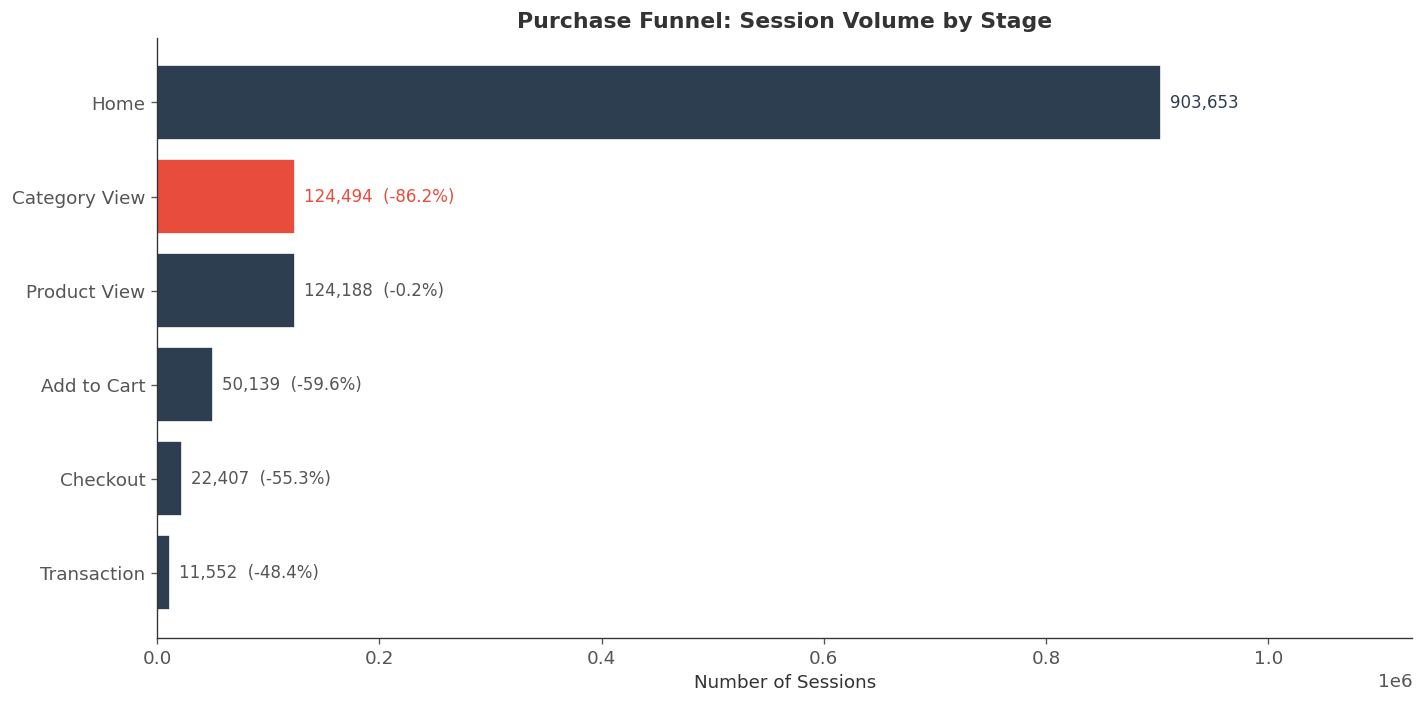

Saved: assets/funnel_volume.png


In [5]:
#ploting
def plot_funnel_bar_chart(totals, labels):
    drop_rates = [0.0]
    for i in range(1, len(totals)):
        drop_rates.append((1 - totals[i] / totals[i - 1]) * 100)

    bar_colors = [colors["primary"]] * len(totals)
    worst_idx = drop_rates.index(max(drop_rates))
    bar_colors[worst_idx] = colors["accent"]

    y_pos = list(range(len(labels) - 1, -1, -1))

    plt.figure(figsize=(12, 6))
    plt.barh(y_pos, totals, color=bar_colors, edgecolor="white")
    plt.yticks(y_pos, labels)
    plt.xlabel("Number of Sessions")
    plt.title("Purchase Funnel: Session Volume by Stage", fontweight="bold")

    for i, (y, count, drop) in enumerate(zip(y_pos, totals, drop_rates)):
        if i == 0:
            plt.text(count + 8000, y, f"{count:,}", va="center", fontsize=10, color=colors["primary"])
        else:
            text_color = colors["accent"] if i == worst_idx else "#555555"
            plt.text(count + 8000, y, f"{count:,}  (-{drop:.1f}%)", va="center", fontsize=10, color=text_color)

    plt.xlim(0, max(totals) * 1.25)
    plt.tight_layout()
    plt.savefig("../assets/funnel_volume.png", dpi=150, bbox_inches="tight")
    plt.show()
    print("Saved: assets/funnel_volume.png")


plot_funnel_bar_chart(overall_totals, STAGE_LABELS)

### 3.1 Drop-Off Waterfall

The waterfall chart isolates sessions lost between consecutive stages.

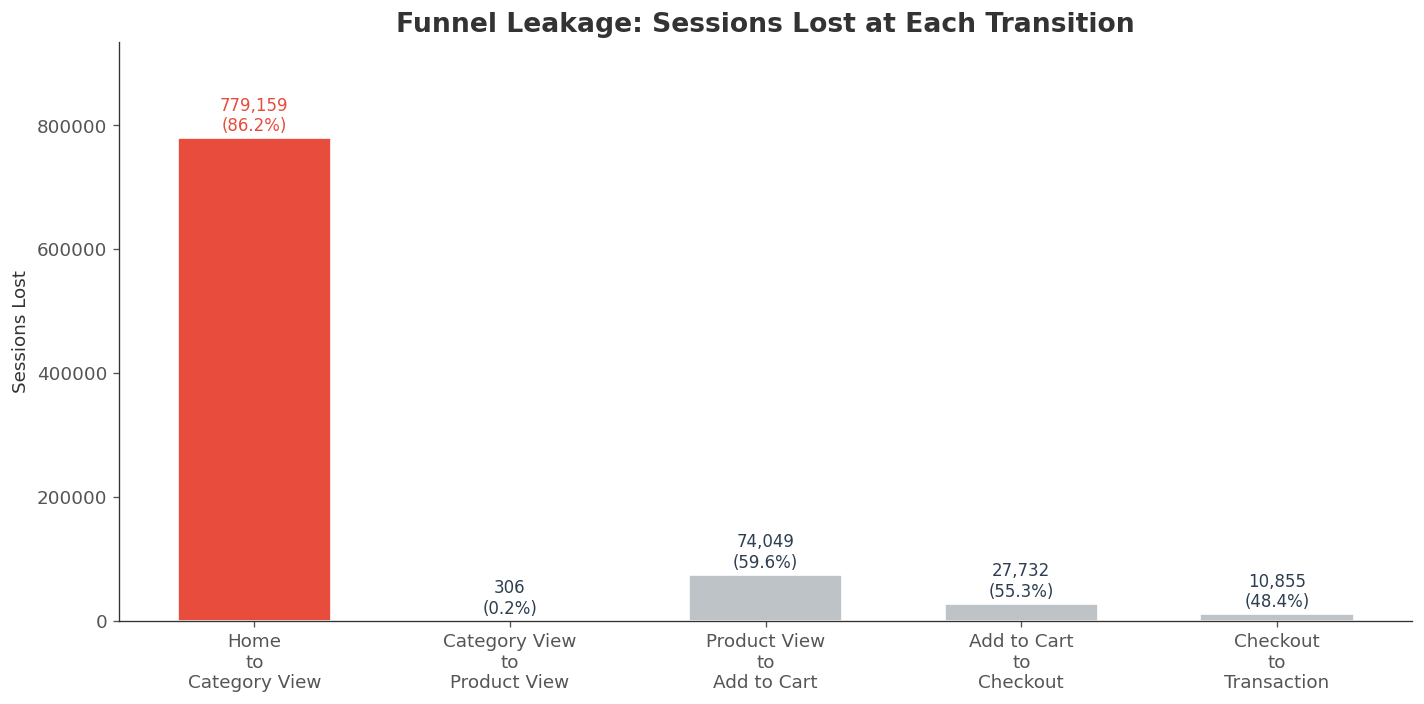

Saved: assets/funnel_waterfall.png


In [6]:
# User drop per step plot
def plot_dropoff_waterfall(totals, labels):
    drops = [totals[i - 1] - totals[i] for i in range(1, len(totals))]
    transition_labels = [f"{labels[i-1]}\nto\n{labels[i]}" for i in range(1, len(labels))]

    bar_colors = [colors["light"]] * len(drops)
    bar_colors[drops.index(max(drops))] = colors["accent"]

    x_pos = range(len(drops))
    plt.figure(figsize=(12, 6))
    plt.bar(x_pos, drops, color=bar_colors, width=0.6, edgecolor="white")
    plt.xticks(x_pos, transition_labels)
    plt.ylabel("Sessions Lost")
    plt.title("Funnel Leakage: Sessions Lost at Each Transition", fontsize=16, fontweight="bold")

    for i, (x, d) in enumerate(zip(x_pos, drops)):
        pct = d / totals[i] * 100
        text_color = colors["accent"] if d == max(drops) else colors["primary"]
        plt.text(x, d + 5000, f"{d:,}\n({pct:.1f}%)", ha="center", va="bottom", fontsize=10, color=text_color)

    plt.ylim(0, max(drops) * 1.2)
    plt.tight_layout()
    plt.savefig("../assets/funnel_waterfall.png", dpi=150, bbox_inches="tight")
    plt.show()
    print("Saved: assets/funnel_waterfall.png")


plot_dropoff_waterfall(overall_totals, STAGE_LABELS)

## 4. Device Segmentation

Quantifying the performance gap at each funnel step to isolate device specific friction points within the user journey.

In [7]:
#funnel
def compute_device_funnel(df, stage_columns, stage_labels):
    devices = ["desktop", "mobile", "tablet"]
    device_data = {}

    print(f"{'Stage':<18}", end="")
    for dev in devices:
        print(f"{dev.upper():>18}", end="")
    print()
    print("-" * 75)

    for col, label in zip(stage_columns, stage_labels):
        print(f"{label:<18}", end="")
        for dev in devices:
            subset = df[df["device_category"] == dev]
            count = subset[col].sum()
            home = subset[stage_columns[0]].sum()
            pct = count / home * 100
            print(f"{pct:>10.2f}% ({count:>6,})", end="")
            if dev not in device_data:
                device_data[dev] = []
            device_data[dev].append(pct)
        print()

    print("_" * 80)
    for dev in devices:
        subset = df[df["device_category"] == dev]
        cr = subset["is_converter"].mean()
        rev = subset["transaction_revenue_usd"].sum()
        print(f"{dev.capitalize()} - CR: {cr:.2%}, Revenue: ${rev:,.0f}")

    return device_data

device_data = compute_device_funnel(funnel, STAGE_COLUMNS, STAGE_LABELS)

Stage                        DESKTOP            MOBILE            TABLET
---------------------------------------------------------------------------
Home              

    100.00% (664,479)    100.00% (208,725)

    100.00% (30,449)
Category View     

     14.28% (94,903)

     12.43% (25,945)     11.97% ( 3,646)
Product View      

     14.25% (94,699)

     12.38% (25,843)     11.97% ( 3,646)
Add to Cart       

      6.09% (40,493)      4.02% ( 8,388)

      4.13% ( 1,258)
Checkout          

      2.91% (19,344)

      1.28% ( 2,677)      1.27% (   386)
Transaction       

      1.58% (10,528)      0.41% (   856)

      0.55% (   168)
________________________________________________________________________________


Desktop - CR: 1.58%, Revenue: $1,711,856
Mobile - CR: 0.41%, Revenue: $56,906


Tablet - CR: 0.55%, Revenue: $11,387


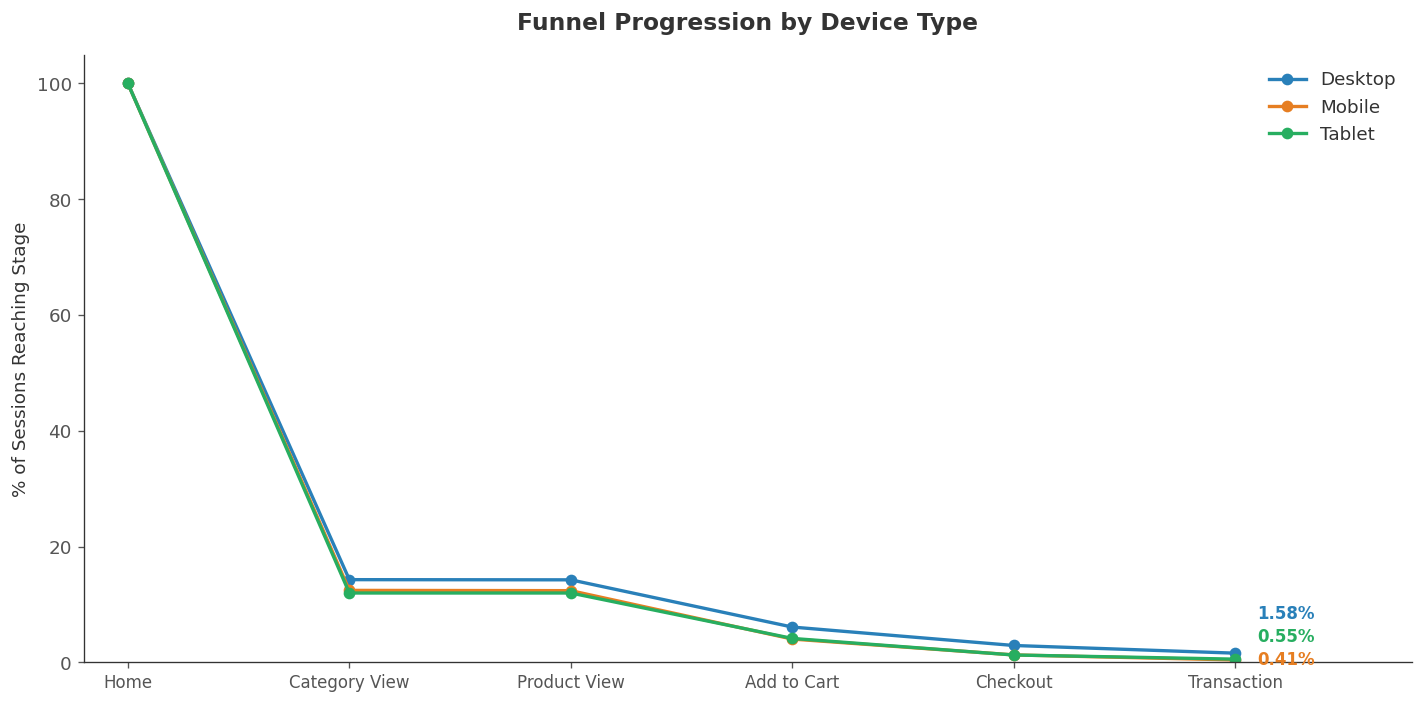

Saved: assets/device_funnel.png


In [8]:
# funnel comparison plot
def plot_device_funnel_comparison(device_data, labels):
    plt.figure(figsize=(12, 6))
    device_colors = {"desktop": colors["desktop"], "mobile": colors["mobile"], "tablet": colors["tablet"]}
    x_pos = range(len(labels))


    devices_sorted = sorted(device_data.keys(), key=lambda d: device_data[d][-1])
    y_texts = {}
    prev_y = -float('inf')

    for d in devices_sorted:
        y_val = device_data[d][-1]
        y_text = max(y_val, prev_y + 4) 
        y_texts[d] = y_text
        prev_y = y_text

    for device, percentages in device_data.items():
        plt.plot(x_pos, percentages, marker="o", linewidth=2, markersize=6,
                 color=device_colors[device], label=device.capitalize())
        
        final_pct = percentages[-1]
        
        plt.text(len(labels) - 0.9, y_texts[device], f"{final_pct:.2f}%",
                 fontsize=10, color=device_colors[device], fontweight="bold", va="center")

    plt.xticks(x_pos, labels, fontsize=10)
    plt.ylabel("% of Sessions Reaching Stage")
    plt.title("Funnel Progression by Device Type", fontsize=14, fontweight="bold", pad=15)
    plt.legend(frameon=False, fontsize=11)
    
    
    plt.xlim(-0.2, len(labels) - 0.2)
    plt.ylim(bottom=0)
    plt.tight_layout()
    plt.savefig("../assets/device_funnel.png", dpi=150, bbox_inches="tight")
    plt.show()
    print("Saved: assets/device_funnel.png")

plot_device_funnel_comparison(device_data, STAGE_LABELS)

## 5. Statistical Validation

Analyzing the conversion delta across device categories to validate the magnitude of performance gaps and establish a baseline for platform specific optimization.

In [9]:
# testing whether desktop and mobile conversion rates differ significantly.
def run_chi_squared_device_test(df):
    desktop = df[df["device_category"] == "desktop"]
    mobile = df[df["device_category"] == "mobile"]

    d_conv = desktop["is_converter"].sum()
    d_no = len(desktop) - d_conv
    m_conv = mobile["is_converter"].sum()
    m_no = len(mobile) - m_conv

    table = np.array([[d_conv, d_no], [m_conv, m_no]])
    chi2, p_value, dof, expected = stats.chi2_contingency(table)

    print("Chi-Squared Test: Desktop vs. Mobile Conversion")
    print("-" * 60)
    print(f"Desktop: {d_conv:,} converters / {len(desktop):,} sessions ({d_conv/len(desktop):.2%})")
    print(f"Mobile:  {m_conv:,} converters / {len(mobile):,} sessions ({m_conv/len(mobile):.2%})")
    print(f"\nChi-Squared Statistic: {chi2:,.2f}")
    print(f"Degrees of Freedom:    {dof}")
    print(f"P-Value:               {p_value:.2e}")
    print("_" * 60)

    if p_value < 0.001:
        print("Interpretation: The difference is highly significant (p < 0.001).")
        print("\nWe can reject the null hypothesis that desktop and mobile convert")
        print("at the same rate. The 3.9x gap is real, not due to chance.")
    elif p_value < 0.05:
        print("Interpretation: The difference is significant (p < 0.05).")
    else:
        print("Interpretation: The difference is not statistically significant.")
    return chi2, p_value

chi2_stat, p_val = run_chi_squared_device_test(funnel)

Chi-Squared Test: Desktop vs. Mobile Conversion
------------------------------------------------------------
Desktop: 10,528 converters / 664,479 sessions (1.58%)
Mobile:  856 converters / 208,725 sessions (0.41%)

Chi-Squared Statistic: 1,701.29
Degrees of Freedom:    1
P-Value:               0.00e+00
____________________________________________________________
Interpretation: The difference is highly significant (p < 0.001).

We can reject the null hypothesis that desktop and mobile convert
at the same rate. The 3.9x gap is real, not due to chance.


In [10]:
# checking direct and referral traffic convert at different rates
def run_chi_squared_channel_test(df):
    direct = df[df["channel_group"] == "Direct"]
    referral = df[df["channel_group"] == "Referral"]

    d_conv = direct["is_converter"].sum()
    d_no = len(direct) - d_conv
    r_conv = referral["is_converter"].sum()
    r_no = len(referral) - r_conv

    table = np.array([[d_conv, d_no], [r_conv, r_no]])
    chi2, p_value, dof, expected = stats.chi2_contingency(table)

    print("Chi-Squared Test: Direct vs. Referral Conversion")
    print("-" * 60)
    print(f"Direct:   {d_conv:,} / {len(direct):,} ({d_conv/len(direct):.2%})")
    print(f"Referral: {r_conv:,} / {len(referral):,} ({r_conv/len(referral):.2%})")
    print(f"\nChi-Squared Statistic: {chi2:,.2f}")
    print(f"P-Value:               {p_value:.2e}")
    print("_" * 60)

    if p_value < 0.001:
        print("Interpretation: highly significant. Referral traffic converts at")
        print("a fundamentally lower rate than direct. This is not noise.")
run_chi_squared_channel_test(funnel)

Chi-Squared Test: Direct vs. Referral Conversion
------------------------------------------------------------
Direct:   8,742 / 371,467 (2.35%)
Referral: 290 / 262,022 (0.11%)

Chi-Squared Statistic: 5,496.99
P-Value:               0.00e+00
____________________________________________________________
Interpretation: highly significant. Referral traffic converts at
a fundamentally lower rate than direct. This is not noise.


## 6. Traffic Channel Analysis

Benchmarking channel specific conversion efficiency to isolate which acquisition sources are driving high intent traffic versus those primarily driving awareness volume.

In [11]:
# Compute conversion rate and total revenue per traffic channel.
def analyze_traffic_channels(df):
    channels = df.groupby("channel_group").agg(
        sessions=("is_converter", "count"),
        conversions=("is_converter", "sum"),
        revenue=("transaction_revenue_usd", "sum"),
    ).sort_values("revenue", ascending=False)

    channels["conversion_rate"] = channels["conversions"] / channels["sessions"]
    channels["revenue_per_session"] = channels["revenue"] / channels["sessions"]

    print(f"{'Channel':<18} {'Sessions':>10} {'Conv':>8} {'CR':>8} {'Revenue':>14} {'Rev/Sess':>10}")
    print("-" * 85)

    for channel, row in channels.iterrows():
        print(f"{channel:<18} {row['sessions']:>10,} {row['conversions']:>8,} "
              f"{row['conversion_rate']:>7.2%} {row['revenue']:>13,.0f} "
              f"${row['revenue_per_session']:>8.2f}")
    return channels

channel_metrics = analyze_traffic_channels(funnel)

Channel              Sessions     Conv       CR        Revenue   Rev/Sess
-------------------------------------------------------------------------------------
Direct              371,467.0  8,742.0   2.35%     1,332,592 $    3.59
Organic Search      234,381.0  2,126.0   0.91%       241,606 $    1.03
Display               6,184.0    141.0   2.28%       130,259 $   21.06
Referral            262,022.0    290.0   0.11%        47,149 $    0.18
Paid Search          13,079.0    243.0   1.86%        27,876 $    2.13
Affiliate            16,403.0      9.0   0.05%           654 $    0.04
Other                   117.0      1.0   0.85%            12 $    0.10


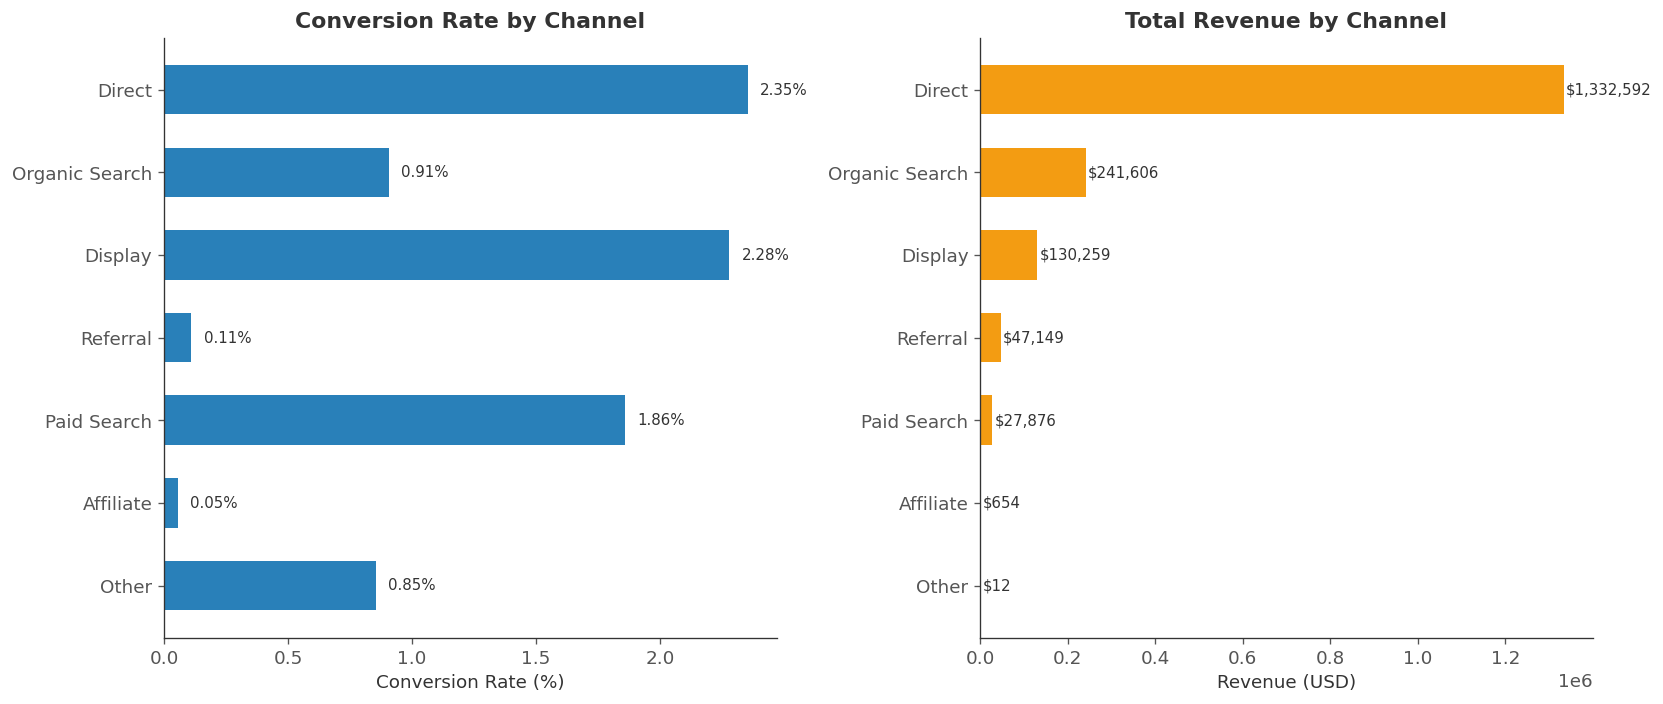

Saved: assets/channel_analysis.png


In [12]:
# Conversion rate and Revenu by channel comparison plot
def plot_channel_conversion_revenue(channel_metrics):
    channels = channel_metrics.sort_values("revenue", ascending=True)
    y_pos = range(len(channels))
    labels = channels.index.tolist()

    plt.figure(figsize=(14, 6))

    plt.subplot(1, 2, 1)
    plt.barh(y_pos, channels["conversion_rate"] * 100, color=colors["desktop"], height=0.6)
    plt.yticks(y_pos, labels)
    plt.xlabel("Conversion Rate (%)")
    plt.title("Conversion Rate by Channel", fontweight="bold")
    for i, (y, cr) in enumerate(zip(y_pos, channels["conversion_rate"])):
        plt.text(cr * 100 + 0.05, y, f"{cr:.2%}", va="center", fontsize=9)

    plt.subplot(1, 2, 2)
    plt.barh(y_pos, channels["revenue"], color=colors["highlight"], height=0.6)
    plt.yticks(y_pos, labels)
    plt.xlabel("Revenue (USD)")
    plt.title("Total Revenue by Channel", fontweight="bold")
    for i, (y, rev) in enumerate(zip(y_pos, channels["revenue"])):
        plt.text(rev + 5000, y, f"${rev:,.0f}", va="center", fontsize=9)

    plt.tight_layout()
    plt.savefig("../assets/channel_analysis.png", dpi=150, bbox_inches="tight")
    plt.show()
    print("Saved: assets/channel_analysis.png")


plot_channel_conversion_revenue(channel_metrics)

## 7. Geographic Concentration
Analyzing the correlation between geographic session distribution and revenue contribution to measure the variance in global revenue per session efficiency.

In [13]:
# US vs International - conversion rate and revenue
def analyze_geographic_performance(df):
    us = df[df["is_us"] == 1]
    intl = df[df["is_us"] == 0]
    total_rev = df["transaction_revenue_usd"].sum()

    print("Geographic Performance: US vs. International")
    print("-" * 60)
    print(f"US:         {len(us):>10,} sessions ({len(us)/len(df):.1%})")
    print(f"           {us['is_converter'].sum():>10,} conversions ({us['is_converter'].mean():.2%} CR)")
    print(f"             ${us['transaction_revenue_usd'].sum():>10,.0f} ({us['transaction_revenue_usd'].sum()/total_rev:.1%} of rev)")
    print(f"\nInternational:{len(intl):>8,} sessions ({len(intl)/len(df):.1%})")
    print(f"        {intl['is_converter'].sum():>10,} conversions ({intl['is_converter'].mean():.2%} CR)")
    print(f"             ${intl['transaction_revenue_usd'].sum():>8,.0f} ({intl['transaction_revenue_usd'].sum()/total_rev:.1%} of rev)")
    print("_" * 60)

    print("\nTop 10 Countries by Conversion (min 1,000 sessions):")
    country_stats = df.groupby("country").agg(
        sessions=("is_converter", "count"), conversions=("is_converter", "sum"),
        revenue=("transaction_revenue_usd", "sum"))
    country_stats["cr"] = country_stats["conversions"] / country_stats["sessions"]
    top = country_stats[country_stats["sessions"] >= 1000].nlargest(10, "cr")
    for country, row in top.iterrows():
        print(f"- {country:<25} CR: {row['cr']:.2%}  ({row['conversions']:,} txns)")

analyze_geographic_performance(funnel)

Geographic Performance: US vs. International
------------------------------------------------------------
US:            364,744 sessions (40.4%)
               10,989 conversions (3.01% CR)
             $ 1,664,261 (93.5% of rev)

International: 538,909 sessions (59.6%)
               563 conversions (0.10% CR)
             $ 115,889 (6.5% of rev)
____________________________________________________________

Top 10 Countries by Conversion (min 1,000 sessions):


- United States             CR: 3.01%  (10,989.0 txns)
- Venezuela                 CR: 2.95%  (63.0 txns)
- Canada                    CR: 0.74%  (191.0 txns)
- (not set)                 CR: 0.41%  (6.0 txns)
- Ecuador                   CR: 0.32%  (4.0 txns)
- Chile                     CR: 0.26%  (5.0 txns)
- Switzerland               CR: 0.20%  (9.0 txns)
- Hong Kong                 CR: 0.19%  (9.0 txns)
- Colombia                  CR: 0.16%  (8.0 txns)
- China                     CR: 0.15%  (6.0 txns)


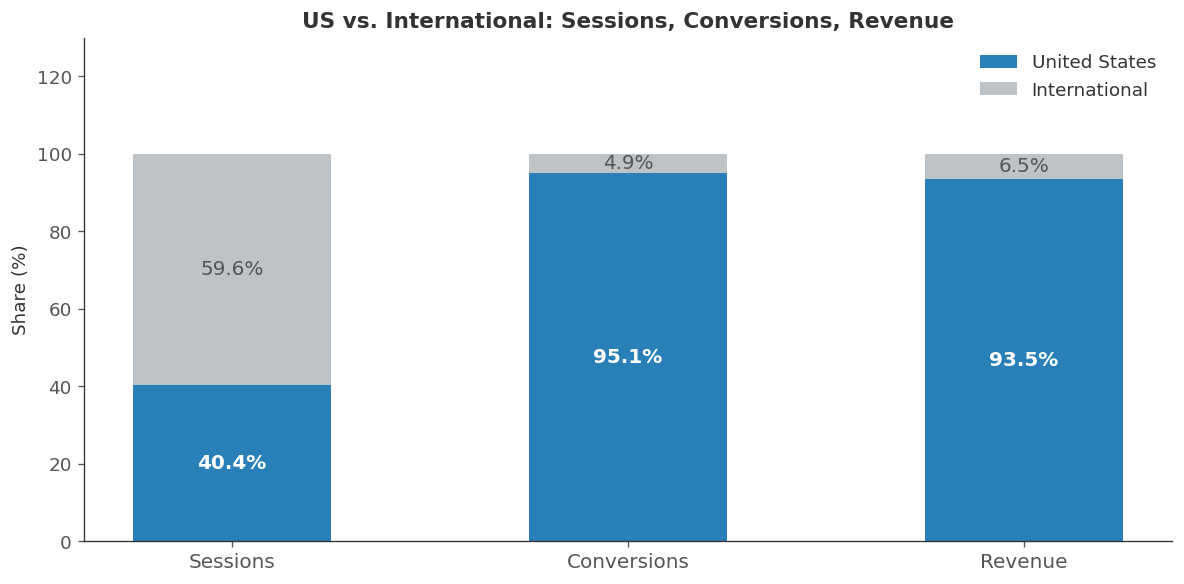

Saved: assets/geo_concentration.png


In [14]:
# Revenue concentration plot
def plot_us_vs_international(df):
    us = df[df["is_us"] == 1]
    intl = df[df["is_us"] == 0]

    categories = ["Sessions", "Conversions", "Revenue"]
    us_vals = [len(us), us["is_converter"].sum(), us["transaction_revenue_usd"].sum()]
    intl_vals = [len(intl), intl["is_converter"].sum(), intl["transaction_revenue_usd"].sum()]

    us_pct = [u / (u + i) * 100 for u, i in zip(us_vals, intl_vals)]
    intl_pct = [i / (u + i) * 100 for u, i in zip(us_vals, intl_vals)]

    x_pos = range(len(categories))
    plt.figure(figsize=(10, 5))
    plt.bar(x_pos, us_pct, color=colors["desktop"], label="United States", width=0.5)
    plt.bar(x_pos, intl_pct, bottom=us_pct, color=colors["light"], label="International", width=0.5)

    for i, (us_p, intl_p) in enumerate(zip(us_pct, intl_pct)):
        plt.text(i, us_p / 2, f"{us_p:.1f}%", ha="center", va="center", fontsize=12, fontweight="bold", color="white")
        plt.text(i, us_p + intl_p / 2, f"{intl_p:.1f}%", ha="center", va="center", fontsize=12, color="#555555")

    plt.xticks(x_pos, categories, fontsize=12)
    plt.ylabel("Share (%)")
    plt.title("US vs. International: Sessions, Conversions, Revenue", fontsize=13, fontweight="bold")
    plt.legend(frameon=False, loc="upper right")
    plt.ylim(0, 130)
    plt.tight_layout()
    plt.savefig("../assets/geo_concentration.png", dpi=150, bbox_inches="tight")
    plt.show()
    print("Saved: assets/geo_concentration.png")


plot_us_vs_international(funnel)

## 8. Product Performance
Benchmarking individual product performance by normalizing revenue against session volume to identify high yield items that may be currently under-promoted.

In [15]:
# Rank of products by rev - computing rev per session efficiency
def analyze_top_products(df):
    df = df.copy()
    df["conversion_rate"] = df["purchases"] / df["sessions"]
    df["revenue_per_session"] = df["total_revenue_usd"] / df["sessions"]

    print("Top 15 Products by Revenue Efficiency")
    print("_" * 90)
    print(f"{'Product':<45} {'Sessions':>8} {'Revenue':>12} {'Rev/Sess':>10}")
    print("-" * 90)
    for _, row in df.nlargest(15, "total_revenue_usd").iterrows():
        name = row["product_name"][:42]
        print(f"{name:<45} {row['sessions']:>8,} ${row['total_revenue_usd']:>10,.0f} ${row['revenue_per_session']:>8.2f}")
    return df

products_enriched = analyze_top_products(products)

Top 15 Products by Revenue Efficiency
__________________________________________________________________________________________
Product                                       Sessions      Revenue   Rev/Sess
------------------------------------------------------------------------------------------
Google 22 oz Water Bottle                          682 $    35,395 $   51.90
Google Men's  Zip Hoodie                           539 $    34,685 $   64.35
26 oz Double Wall Insulated Bottle                 421 $    33,455 $   79.47
Leatherette Journal                                261 $    29,855 $  114.39
Google Sunglasses                                  731 $    29,527 $   40.39
Recycled Paper Journal Set                         391 $    24,936 $   63.78
Google Men's 100% Cotton Short Sleeve Hero         639 $    22,137 $   34.64
Sport Bag                                          320 $    20,972 $   65.54
Google 17oz Stainless Steel Sport Bottle           251 $    20,240 $   80.64
Google M

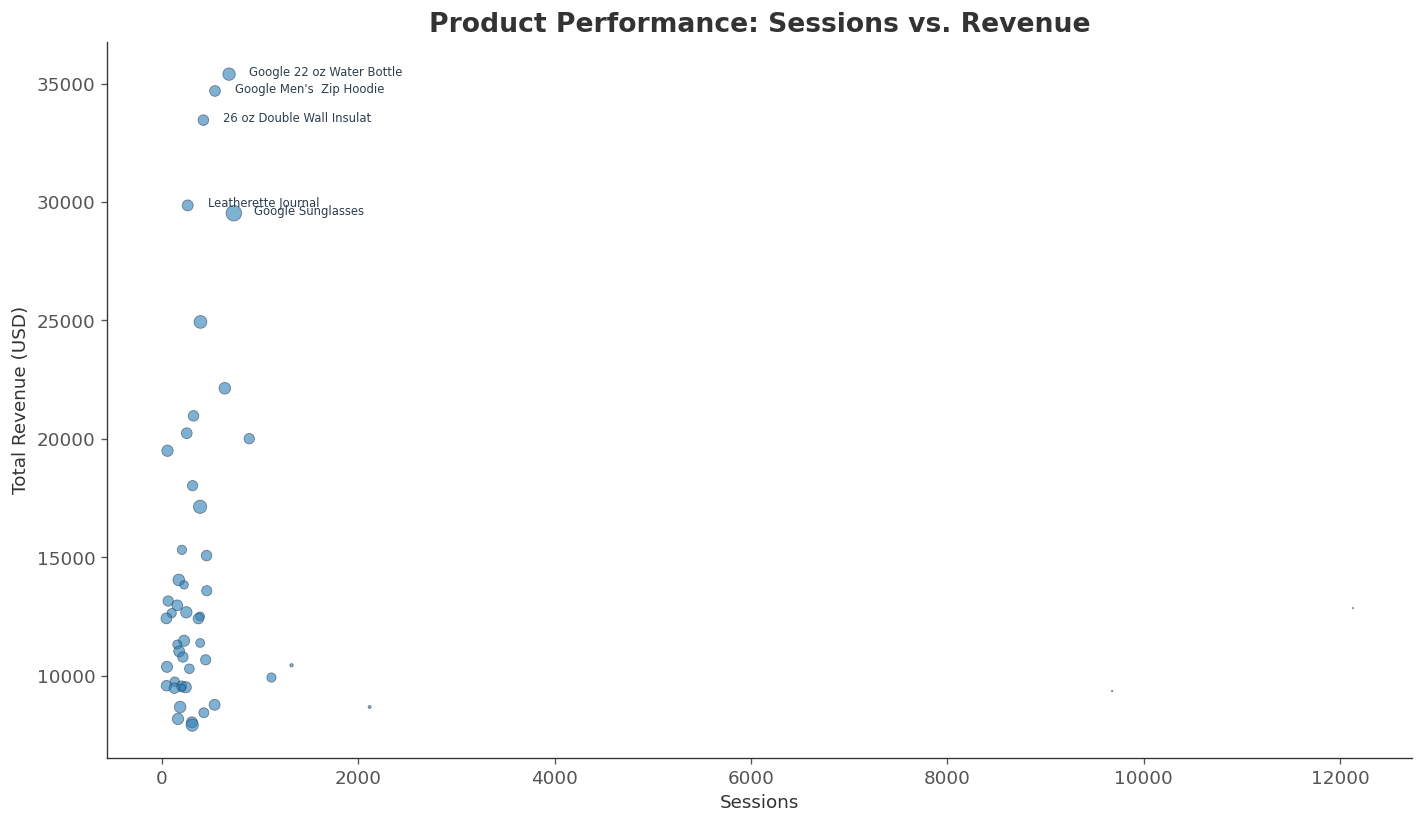

Saved: assets/product_scatter.png


In [16]:
def plot_product_scatter(df):
    """Scatter plot of sessions vs. revenue for top products.

    Business reason: Top-right = winners; bottom-right = optimization targets.
    """
    df = df.copy()
    df["conversion_rate"] = df["purchases"] / df["sessions"]
    top = df.nlargest(50, "total_revenue_usd")

    plt.figure(figsize=(12, 7))
    plt.scatter(top["sessions"], top["total_revenue_usd"], s=top["conversion_rate"] * 30,
                c=colors["desktop"], alpha=0.6, edgecolors=colors["primary"], linewidths=0.5)

    for _, row in top.nlargest(5, "total_revenue_usd").iterrows():
        plt.annotate(row["product_name"][:25], (row["sessions"], row["total_revenue_usd"]),
                     textcoords="offset points", xytext=(12, -1), fontsize=7, color=colors["primary"])

    plt.xlabel("Sessions")
    plt.ylabel("Total Revenue (USD)")
    plt.title("Product Performance: Sessions vs. Revenue", fontsize=16, fontweight="bold")
    plt.tight_layout()
    plt.savefig("../assets/product_scatter.png", dpi=150, bbox_inches="tight")
    plt.show()
    print("Saved: assets/product_scatter.png")

plot_product_scatter(products)

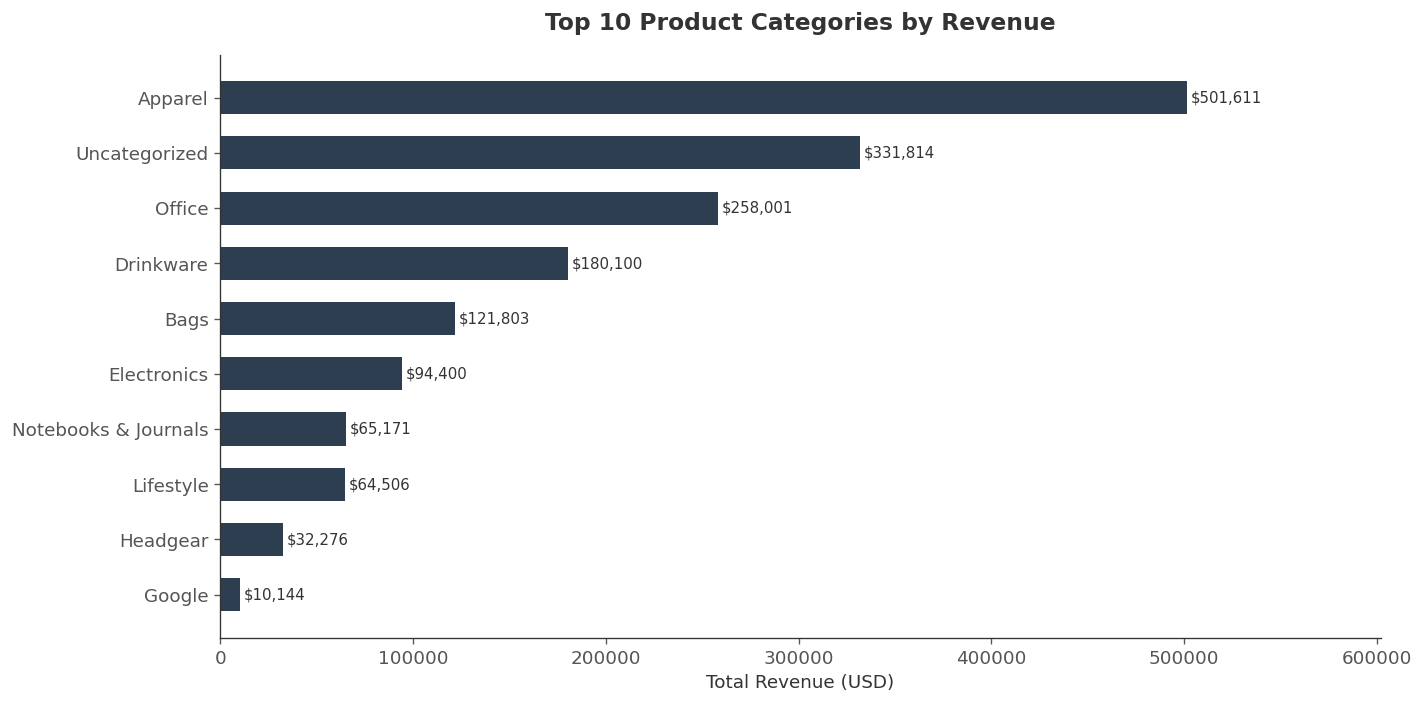

Saved: assets/category_revenue.png


In [17]:
# Top 10 product categories by revenue plot
def plot_category_revenue(df):
    df = df.copy()
    placeholders = ["(not set)", "${escCatTitle}", "(not provided)"]
    df["cat"] = df["product_category"].apply(lambda x: "Uncategorized" if x in placeholders else x)
    df["cat"] = df["cat"].str.replace("Home/", "", regex=False).str.strip("/")

    cat_rev = df.groupby("cat")["total_revenue_usd"].sum().nlargest(10)
    y_pos = range(len(cat_rev))

    plt.figure(figsize=(12, 6))
    plt.barh(y_pos, cat_rev.values, color=colors["primary"], height=0.6)
    plt.yticks(y_pos, [c[:30] for c in cat_rev.index])
    plt.xlabel("Total Revenue (USD)")
    plt.title("Top 10 Product Categories by Revenue", fontsize=14, fontweight="bold", pad=15)

    for y, rev in zip(y_pos, cat_rev.values):
        plt.text(rev + 2000, y, f"${rev:,.0f}", va="center", fontsize=9)

    plt.xlim(0, max(cat_rev.values) * 1.2)
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.savefig("../assets/category_revenue.png", dpi=150, bbox_inches="tight")
    plt.show()
    print("Saved: assets/category_revenue.png")
    


plot_category_revenue(products)

## 9. Engagement and Conversion Relationship

Map the relationship between engagement depth and conversion velocity, allowing to isolate whether drop-offs are driven by top-of-funnel 'interest gaps' or bottom-of-funnel 'transactional barriers.

In [18]:
# Conversion rate by engagement tier and time-on-site bucket
def analyze_engagement_conversion(df):
    df["duration_bucket"] = pd.cut(
        df["time_on_site"], bins=[-1, 0, 60, 300, 100000],
        labels=["Zero (Bounce)", "Under 1 min", "1-5 min", "Over 5 min"])

    print("Conversion Rate by Engagement Tier")
    print("-" * 55)
    for tier in ["Bounce", "Low", "Medium", "High"]:
        subset = df[df["engagement_tier"] == tier]
        print(f"  {tier:<12} {len(subset):>10,} sessions    CR: {subset['is_converter'].mean():.2%}")
        
    print("_" * 55)
    print("\nConversion Rate by Time on Site")
    print("-" * 55)
    for bucket in ["Zero (Bounce)", "Under 1 min", "1-5 min", "Over 5 min"]:
        subset = df[df["duration_bucket"] == bucket]
        print(f"  {bucket:<18} {len(subset):>10,} sessions    CR: {subset['is_converter'].mean():.2%}")
 

analyze_engagement_conversion(funnel)

Conversion Rate by Engagement Tier
-------------------------------------------------------
  Bounce          452,622 sessions    CR: 0.00%


  Low             217,605 sessions    CR: 0.00%
  Medium          122,767 sessions    CR: 0.04%
  High            110,659 sessions    CR: 10.38%
_______________________________________________________

Conversion Rate by Time on Site
-------------------------------------------------------


  Zero (Bounce)         451,759 sessions    CR: 0.00%
  Under 1 min           191,095 sessions    CR: 0.00%
  1-5 min               159,806 sessions    CR: 0.77%


  Over 5 min            100,993 sessions    CR: 10.22%


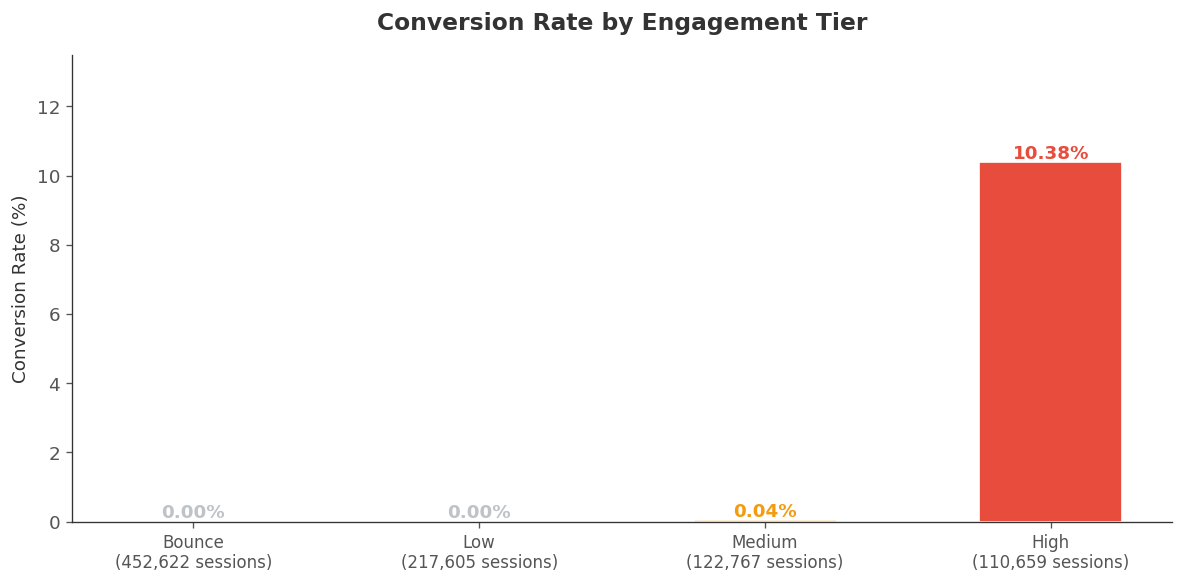

Saved: engagement_conversion/category_revenue.png


In [19]:
# Conversion rate by engagment tier plot
def plot_engagement_vs_conversion(df):
   
    tiers = ["Bounce", "Low", "Medium", "High"]
    crs = []
    counts = []
    for tier in tiers:
        subset = df[df["engagement_tier"] == tier]
        crs.append(subset["is_converter"].mean() * 100)
        counts.append(len(subset))

    x_pos = range(len(tiers))
    color_scheme = [colors["light"], colors["light"], colors["highlight"], colors["accent"]]

    plt.figure(figsize=(10, 5))
    plt.bar(x_pos, crs, color=color_scheme, width=0.5, edgecolor="white")
    plt.xticks(x_pos, [f"{t}\n({c:,} sessions)" for t, c in zip(tiers, counts)], fontsize=10)
    plt.ylabel("Conversion Rate (%)")
    plt.title("Conversion Rate by Engagement Tier", fontsize=14, fontweight="bold", pad=15)

    for i, (x, cr) in enumerate(zip(x_pos, crs)):
        plt.text(x, cr + 0.1, f"{cr:.2f}%", ha="center", fontsize=11, fontweight="bold", color=color_scheme[i])

    plt.ylim(0, max(crs) * 1.3)
    plt.tight_layout()
    plt.savefig("../assets/engagement_conversion.png", dpi=150, bbox_inches="tight")
    plt.show()
    print("Saved: engagement_conversion/category_revenue.png")

plot_engagement_vs_conversion(funnel)

## 10. Executive Summary of Findings

The Google Merchandise Store converts 1.28% of 903K sessions, generating $1.78M in revenue. Five structural bottlenecks are leaving significant money on the table.

**1) The top of the funnel is broken.**  
86.2% of homepage visitors never browse a single category, 779K sessions lost before the funnel even starts.   
60% of viewers abandon at product detail page withoutadding to cart.

**2) Mobile is underperforming with a 3.9x conversion gap (statistically significant).**  
Desktop converts at 1.58%, mobile at 0.41%. Chi-Squared: chi2 = 1,701, p < 0.001. The gap is real.   
Closing even half that gap would yield ~2,400 additional transactions.

**3) Traffic quality is missalocated.**  
Referral traffic delivers 29% of sessions but converts at 0.11%, 21x worse than direct.  
International traffic follows a similar path with 60% of sessions but only 2.4% of revenue.

**Finding 4: Revenue is dangerously concentrated in the US.**  
40.4% of sessions, 97.6% of revenue. International traffic generates negligible returns.

**Finding 5: Engagement depth is the strongest predictor of conversion.**  
Users viewing 7+ pages convert at dramatically higher rates. Invest in browse depth, not just checkout.

**Strategic Reccomendations: ~$479K in incremental revenue across four initiatives**  
Homepage redesign, mobile checkout overhaul, product page optimization, and referral channel reallocation.   
The highest-ROI move is the homepage — largest volume impact, lowest implementation cost.

---

*Detailed strategic recommendations: `docs/strategy_brief.md`*
